In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

## A Python library for Machine Learning: scikit-learn

You might have noticed that running our implementation of $k$-NNs for 20000 samples already started to feel a bit sluggish... That is because it isn't really optimized. If we wanted things to be fast, we would have to recur to some C code, using Python extensions such as Cython or ctypes (that's actually what packages such as Numpy and Scipy do for us).
Moreover, we did things very naively -- for instance, one actually does not need to compute the full distance matrix if using appropriate data structures such as kd-trees etc.

Luckily for us there are people who already wrote optimized versions of most standard machine learning algorithms!

![scikit-learn website](sklearn.png)

So let's see how scikit-learn's k-NN implementation works. One nice thing about scikit-learn is that they have lots of examples available online, so we can just look for something similar to what we are trying to do. For k-NN classification in particular there's this: http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

In [13]:
# Samples 10 centroids for each class from two different bivariate Normal distributions
centroids_per_class = 10

class0_centroids = [1, 0] + np.random.randn(centroids_per_class, 2)
class1_centroids = [0, 1] + np.random.randn(centroids_per_class, 2)

samples_per_class = 100

# Sample actual data sampling from Normal distributions positioned around the centroids (Pick the centroid of the chosen class uniformly)
class0_labels = np.random.randint(10, size = samples_per_class)
class1_labels = np.random.randint(10, size = samples_per_class)

class0_samples = class0_centroids[class0_labels, :] + np.sqrt(1. / 5) * np.random.randn(samples_per_class, 2)
class1_samples = class1_centroids[class1_labels, :] + np.sqrt(1. / 5) * np.random.randn(samples_per_class, 2)

# Let's use the stack function to build the feature matrix and vector of labels 
X = np.vstack((class0_samples, class1_samples))
y = np.hstack((np.zeros(samples_per_class), np.ones(samples_per_class)))

# Sample test data from the model
testsamples_per_class = 10000

class0_testlabels = np.random.randint(10, size = testsamples_per_class)
class1_testlabels = np.random.randint(10, size = testsamples_per_class)
class0_testsamples = class0_centroids[class0_testlabels, :] + np.sqrt(1. / 5) * np.random.randn(testsamples_per_class, 2)
class1_testsamples = class1_centroids[class1_testlabels, :] + np.sqrt(1. / 5) * np.random.randn(testsamples_per_class, 2)

X_test = np.vstack((class0_testsamples, class1_testsamples))
y_test = np.hstack((np.zeros(testsamples_per_class), np.ones(testsamples_per_class)))

In [14]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(10)
clf.fit(X, y)

KNeighborsClassifier(n_neighbors=10)

And done! With just three lines of code we were able to repeat everything we've been doing so far. Let us see if we get the same training error as before.

In [15]:
train_error = np.mean(y != clf.predict(X))
test_error = np.mean(y_test != clf.predict(X_test))
#train_error = 1. - clf.score(X, y)
#test_error = 1. - clf.score(X_test, y_test)

print("train/test error (for k = 10): %g/%g" % (train_error, test_error))

train/test error (for k = 10): 0.21/0.26535


Since things are optimized here, we can even do cooler things such as plotting the actual decision boundaries. In order to do that, let us generate a grid and compute the estimate for each point in that grid.

/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_16517/2254314960.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap = "coolwarm", alpha = 0.2)


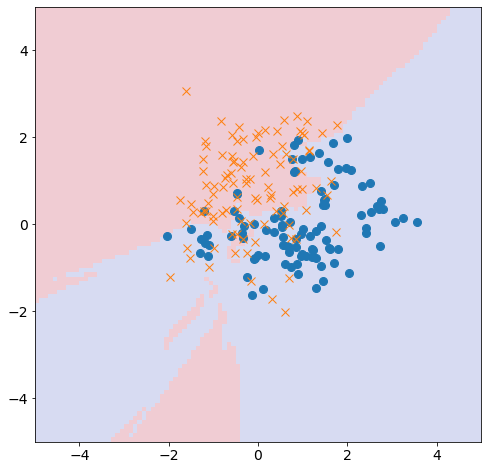

In [16]:
# Create a grid
xx, yy = np.meshgrid(np.linspace(-5, 5, 101), np.linspace(-5, 5, 101))
zz = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Do some plotting
zz = zz.reshape(xx.shape)
plt.pcolormesh(xx, yy, zz, cmap = "coolwarm", alpha = 0.2)
plt.plot(X[y == 0, 0], X[y == 0, 1], "o", markersize=8)
plt.plot(X[y == 1, 0], X[y == 1, 1], "x", markersize=8)

### Determining the best value of $k$ by cross-validation

One way of determining the "best" value of $k$ is by partitioning our dataset into two (training and validation sets) and then adjusting its value so as to minimize the validation error (we then need a 3rd set where we can compute the test error -- never adjust your parameters and compute the test error using the same set!)

However, this does not provide us good statistics since the partitioning is only done once; a perhaps better way of doing it is by partitioning the dataset again and again, and recomputing the score. This is the idea behind cross-validation.

scikit-learn has nice convenience functions to perform cross-validation for us.

In [17]:
from sklearn.model_selection import GridSearchCV

# Set up the grid search
parameters = [{'n_neighbors': np.arange(1, 20)}]
clf = GridSearchCV(neighbors.KNeighborsClassifier(n_neighbors = 1), parameters)
clf.fit(X, y)

# Print results
print(clf.best_params_)
print(clf.cv_results_["mean_test_score"])

{'n_neighbors': 17}
[0.72  0.705 0.715 0.72  0.735 0.755 0.765 0.775 0.76  0.77  0.765 0.74
 0.73  0.72  0.73  0.745 0.78  0.76  0.77 ]


Let's see how this does on the test set.

In [18]:
train_error = np.mean(y != clf.predict(X))
test_error = np.mean(y_test != clf.predict(X_test))
print("train/test error (for optimal k): %g/%g" % (train_error, test_error))

train/test error (for optimal k): 0.22/0.2506


## Classification on real datasets: MNIST

Finally, let us work with a real dataset! If you have already studied a bit of machine learning and statistics, you are probably familiar with the MNIST dataset of handwritten digits. It is one of the most famous datasets used for benchmarking clustering and classification algorithms.

It is also included in scikit-learn. Let's see how to get it.

In [19]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(X.shape, y.shape)

(70000, 784) (70000,)


Let's take a look at the data to see how it looks like.

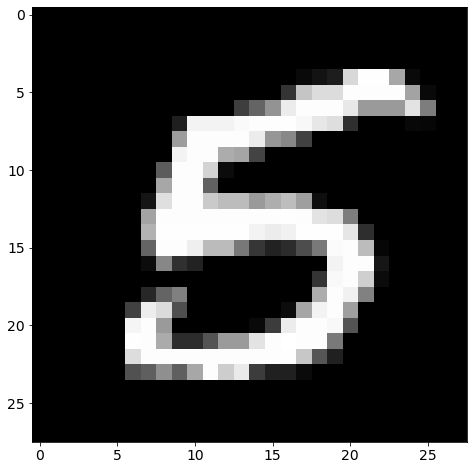

In [20]:
n_samples, n_features = np.shape(X)

# Plot a sample
plt.imshow(X[20000, :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")

In [25]:
# Partition set into train/test
samples = np.random.randint(60000, size = 1000)
X_train, y_train = X[samples, :], y[samples]
X_test, y_test = X[60000:, :], y[60000:]

In [26]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

train_error = 1. - clf.score(X_train, y_train)
test_error = 1. - clf.score(X_test, y_test)
print("train/test error: %g/%g" % (train_error, test_error))

train/test error: 0.09/0.1227


This is good but not so much... Try with a bigger subset of the dataset... It's quite slow. 

Text(0.5, 1.0, 'Class:5')

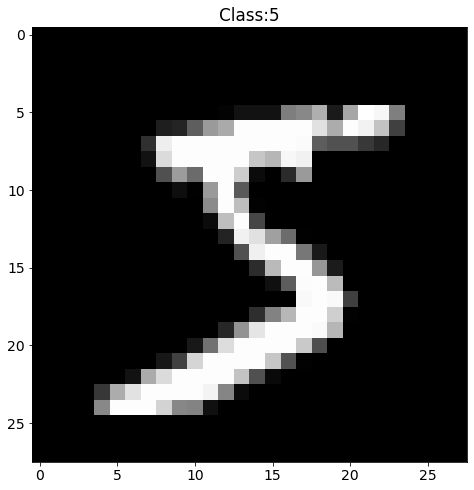

In [31]:
i=0
plt.imshow(X[i, :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")
plt.title(f"Class:{y[i]}")